In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [ ]:
os.environ["KAGGLE_USERNAME"] = "magdhndi"
os.environ["KAGGLE_KEY"] = "9b6c8953fb75d807a407f863ae22edc6"

In [ ]:
!kaggle datasets download meirnizri/covid19-dataset

Dataset URL: https://www.kaggle.com/datasets/meirnizri/covid19-dataset
License(s): CC0-1.0
 86% 4.00M/4.66M [00:00<00:00, 6.10MB/s]
100% 4.66M/4.66M [00:00<00:00, 5.04MB/s]


In [ ]:
!unzip covid19-dataset

Archive:  covid19-dataset.zip
  inflating: Covid Data.csv          


In [ ]:
def clean_data(df):
    """
    Clean the tabular data by handling missing values and encoding categorical variables.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    # Handle missing values: replace '97' and '99' with NaN
    df.replace([97, 98, 99], pd.NA, inplace=True)

    # Fill missing values with appropriate strategies
    df['AGE'].fillna(df['AGE'].mode()[0], inplace=True)
    categorical_columns = ['SEX', 'PATIENT_TYPE', 'PREGNANT', 'DIABETES', 'COPD',
                           'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'CARDIOVASCULAR',
                           'RENAL_CHRONIC', 'OBESITY', 'TOBACCO',
                           'USMER', 'INTUBED', 'ICU']

    for column in categorical_columns:
        df[column].fillna(df[column].mode()[0], inplace=True)

    # Encode categorical variables
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    return df


In [ ]:
def feature_engineering(df):
    """
    Engineer features from the cleaned data.

    Args:
        df (pd.DataFrame): Cleaned DataFrame.

    Returns:
        pd.DataFrame: DataFrame with engineered features.
    """
    # Create a new feature 'pneumonia' based on conditions
    df['PNEUMONIA'] = (df['PNEUMONIA'] == 1)
    df['PNEUMONIA'] = df['PNEUMONIA'].astype(int)

    return df


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_data(df):
    """
    Normalize numerical features in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with engineered features.

    Returns:
        pd.DataFrame: DataFrame with normalized numerical features.
    """
    numerical_columns = ['AGE']

    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df


In [ ]:
# prompt: in preprocessed_data['CLASIFFICATION_FINAL'] convert values 1,2 and 3 to 1 and convert 4,5,6,7 to 0

def convert_labels(data):
  """
  Converts labels in the 'CLASIFFICATION_FINAL' column to 1 for values 1, 2, and 3, and 0 for values 4, 5, 6, and 7.

  Args:
    data (pd.DataFrame): DataFrame containing the data.

  Returns:
    pd.DataFrame: DataFrame with converted labels.
  """

  data['CLASIFFICATION_FINAL'] = data['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

  # Drop columns which not needed for classification
  data.drop(['DATE_DIED'], axis=1, inplace=True)
  data.drop(['MEDICAL_UNIT'], axis=1, inplace=True)
  data.drop(['OTHER_DISEASE'], axis=1, inplace=True)

  return data


In [ ]:
def preprocess_data(file_path):
    """
    Load, clean, and preprocess the tabular data.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Preprocessed DataFrame ready for model training.
    """
    df = pd.read_csv(file_path)
    df = convert_labels(df)
    df = clean_data(df)
    df = feature_engineering(df)
    df = normalize_data(df)

    return df


In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [ ]:
from sklearn.model_selection import train_test_split

def partition_data(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Partition data into training, validation, and test sets.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target labels.
        test_size (float): Proportion of the data to be used for testing.
        val_size (float): Proportion of the data to be used for validation.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: Split data (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_size + val_size), random_state=random_state)
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
from imblearn.over_sampling import SMOTE

def balance_classes(X_train, y_train):
    """
    Balance the classes in the training set using SMOTE.

    Args:
        X_train (pd.DataFrame): Training feature DataFrame.
        y_train (pd.Series): Training target labels.

    Returns:
        tuple: Balanced training data (X_train_balanced, y_train_balanced)
    """
    # Initialize SMOTE with a random state
    smote = SMOTE(random_state=42)

    # Fit and transform the data
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    return X_train_balanced, y_train_balanced


Define a function to randomly replace a percentage of values ​​in a column

In [ ]:
def random_replace(df, column, original_value, new_value, percentage):
    """
    Randomly replace a percentage of instances of a value in a DataFrame column with a new value.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column in which to replace values.
        original_value (any): The original value to be replaced.
        new_value (any): The new value to replace the original value with.
        percentage (float): The percentage of original values to replace.

    Returns:
        None
    """
    # Check if the column exists in the DataFrame
    if column not in df.columns:
        raise ValueError(f"Column {column} does not exist in the DataFrame.")

    # Count the total occurrences of the original value
    total_values = df[column].value_counts().get(original_value, 0)

    # Calculate the number of values to replace
    n_replace = int(total_values * (percentage / 100))

    # Sample the indices to replace
    if n_replace > 0:
        replace_indices = df[df[column] == original_value].sample(n=n_replace, random_state=42).index
        df.loc[replace_indices, column] = new_value
    else:
        print(f"No values to replace for {original_value} in column {column}.")


Get Data From Database

In [ ]:
file_path = '/content/Covid Data.csv'


In [ ]:
preprocessed_data = preprocess_data(file_path)


new

In [ ]:
df = pd.read_csv(file_path)


In [ ]:
df = convert_labels(df)


In [ ]:
df = clean_data(df)


In [ ]:

preprocessed_data.shape

(1048575, 18)

In [ ]:
sample = df.iloc[0]

In [ ]:
sample.shape

(18,)

In [ ]:
d1 = sample.to_dict()
for k,v in d1.items():
  d1[k] = [v,]

In [ ]:
print(d1)

{'PNEUMONIA': [1], 'AGE': [65], 'CLASIFFICATION_FINAL': [1], 'SEX_2': [False], 'PATIENT_TYPE_2': [False], 'PREGNANT_2': [True], 'DIABETES_2': [True], 'COPD_2': [True], 'ASTHMA_2': [True], 'INMSUPR_2': [True], 'HIPERTENSION_2': [False], 'CARDIOVASCULAR_2': [True], 'RENAL_CHRONIC_2': [True], 'OBESITY_2': [True], 'TOBACCO_2': [True], 'USMER_2': [True], 'INTUBED_2': [True], 'ICU_2': [True]}


In [ ]:
magd_df = pd.DataFrame(d1)
#magd_df[0] = pd.Series(d1)


In [ ]:
magd_sample = magd_df.iloc[0]

In [ ]:
magd_sample.shape

(18,)

In [ ]:
print(type(magd_sample))
print(magd_sample)

<class 'pandas.core.series.Series'>
PNEUMONIA                   1
AGE                        65
CLASIFFICATION_FINAL        1
SEX_2                   False
PATIENT_TYPE_2          False
PREGNANT_2               True
DIABETES_2               True
COPD_2                   True
ASTHMA_2                 True
INMSUPR_2                True
HIPERTENSION_2          False
CARDIOVASCULAR_2         True
RENAL_CHRONIC_2          True
OBESITY_2                True
TOBACCO_2                True
USMER_2                  True
INTUBED_2                True
ICU_2                    True
Name: 0, dtype: object


In [ ]:
print(type(sample))
print(sample)

<class 'pandas.core.series.Series'>
PNEUMONIA                   1
AGE                        65
CLASIFFICATION_FINAL        1
SEX_2                   False
PATIENT_TYPE_2          False
PREGNANT_2               True
DIABETES_2               True
COPD_2                   True
ASTHMA_2                 True
INMSUPR_2                True
HIPERTENSION_2          False
CARDIOVASCULAR_2         True
RENAL_CHRONIC_2          True
OBESITY_2                True
TOBACCO_2                True
USMER_2                  True
INTUBED_2                True
ICU_2                    True
Name: 0, dtype: object


old

In [ ]:
preprocessed_data.shape

(1048575, 18)

In [ ]:
sample = preprocessed_data.iloc[0]

In [ ]:
sample.shape

(18,)

In [ ]:
sample

PNEUMONIA                      1
AGE                     1.376234
CLASIFFICATION_FINAL           1
SEX_2                      False
PATIENT_TYPE_2             False
PREGNANT_2                  True
DIABETES_2                  True
COPD_2                      True
ASTHMA_2                    True
INMSUPR_2                   True
HIPERTENSION_2             False
CARDIOVASCULAR_2            True
RENAL_CHRONIC_2             True
OBESITY_2                   True
TOBACCO_2                   True
USMER_2                     True
INTUBED_2                   True
ICU_2                       True
Name: 0, dtype: object

Split the data into features and labels

In [ ]:
preprocessed_data['CLASIFFICATION_FINAL'].value_counts()

CLASIFFICATION_FINAL
0    656596
1    391979
Name: count, dtype: int64

In [ ]:
X = preprocessed_data
y = preprocessed_data['CLASIFFICATION_FINAL']
X.rename(columns={'CLASIFFICATION_FINAL': 'CLASIFFICATION'}, inplace=True)

Partition the data to train, val, test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = partition_data(X, y)


balance the data

In [ ]:
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

Create Fake Error with suituble Rate

In [ ]:
# Randomly replace 2.04% of cases where CLASIFFICATION is 1 with 0
random_replace(X_train_balanced, 'CLASIFFICATION', 1, 0, 2.04)
random_replace(X_val, 'CLASIFFICATION', 1, 0, 2.04)
random_replace(X_test, 'CLASIFFICATION', 1, 0, 2.04)

# Randomly replace 3.07% of cases where CLASIFFICATION is 0 with 1
random_replace(X_train_balanced, 'CLASIFFICATION', 0, 1, 3.07)
random_replace(X_val, 'CLASIFFICATION', 0, 1, 3.07)
random_replace(X_test, 'CLASIFFICATION', 0, 1, 3.07)

# Randomly replace 4.63% of cases where PNEUMONIA is 0 with 1
random_replace(X_train_balanced, 'PNEUMONIA', 0, 1, 4.63)
random_replace(X_val, 'PNEUMONIA', 0, 1, 4.63)
random_replace(X_test, 'PNEUMONIA', 0, 1, 4.63)


Chreak Shape of Data

In [ ]:
X_train_balanced.shape, y_train_balanced.shape

((918788, 18), (918788,))

In [ ]:
X_val.shape , y_val.shape

((157286, 18), (157286,))

In [ ]:
X_test.shape , y_test.shape

((157287, 18), (157287,))

#Cheak point step

Save Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

X_train_balanced.to_csv('/content/drive/My Drive/X_train_balanced.csv', index=False)
y_train_balanced.to_csv('/content/drive/My Drive/y_train_balanced.csv', index=False)

X_val.to_csv('/content/drive/My Drive/X_val.csv', index=False)
y_val.to_csv('/content/drive/My Drive/y_val.csv', index=False)

X_test.to_csv('/content/drive/My Drive/X_test.csv', index=False)
y_test.to_csv('/content/drive/My Drive/y_test.csv', index=False)


Get Data

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [2]:
from google.colab import drive
drive.mount('/content/drive')

X_train_balanced = pd.read_csv('/content/drive/My Drive/X_train_balanced.csv')
y_train_balanced = pd.read_csv('/content/drive/My Drive/y_train_balanced.csv')

X_val = pd.read_csv('/content/drive/My Drive/X_val.csv')
y_val = pd.read_csv('/content/drive/My Drive/y_val.csv')

X_test = pd.read_csv('/content/drive/My Drive/X_test.csv')
y_test = pd.read_csv('/content/drive/My Drive/y_test.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Now continue to the rest of code

In [3]:
X_train_balanced.shape, X_val.shape, X_test.shape

((918788, 18), (157286, 18), (157287, 18))

Get addition data after we include suitable error rate

In [4]:
additional_train = X_train_balanced[['PNEUMONIA', 'CLASIFFICATION']]
additional_val = X_val[['PNEUMONIA', 'CLASIFFICATION']]
additional_test = X_test[['PNEUMONIA', 'CLASIFFICATION']]


Drop addition data from main data

In [5]:
X_train_balanced = X_train_balanced.drop(['PNEUMONIA', 'CLASIFFICATION'], axis=1)
X_val = X_val.drop(['PNEUMONIA', 'CLASIFFICATION'], axis=1)
X_test = X_test.drop(['PNEUMONIA', 'CLASIFFICATION'], axis=1)


Cheak data shape

In [6]:
X_train_balanced.shape, X_val.shape, X_test.shape

((918788, 16), (157286, 16), (157287, 16))

In [7]:
additional_train.shape, additional_val.shape, additional_test.shape

((918788, 2), (157286, 2), (157287, 2))

In [8]:
y_train_balanced.shape, y_val.shape, y_test.shape

((918788, 1), (157286, 1), (157287, 1))

In [9]:
y_train_balanced['CLASIFFICATION_FINAL'].value_counts()

CLASIFFICATION_FINAL
1    459394
0    459394
Name: count, dtype: int64

In [ ]:
def check_training_data(df, target_column):
    # Initialize a report dictionary to store results of checks
    report = {
        'missing_values': None,
        'data_types': None,
        'class_balance': None,
        'duplicate_rows': None,
        'outliers': None
    }

    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.any():
        report['missing_values'] = missing_values[missing_values > 0]
    else:
        report['missing_values'] = "No missing values"

    # Check data types
    report['data_types'] = df.dtypes

    # Check for class imbalance in the target variable
    class_counts = df[target_column].value_counts()
    report['class_balance'] = class_counts

    # Check for duplicate rows
    duplicate_rows = df.duplicated().sum()
    if duplicate_rows > 0:
        report['duplicate_rows'] = f"{duplicate_rows} duplicate rows found"
    else:
        report['duplicate_rows'] = "No duplicate rows"

    # Check for outliers in numerical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    outliers = {}
    for column in numerical_columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers[column] = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

    report['outliers'] = outliers

    # Print the report
    for key, value in report.items():
        print(f"{key.capitalize()}: {value}")

    # Return the report
    return report


In [ ]:
!pip install imblearn
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
check_training_data(X_train_balanced, y_train_balanced)

Missing_values: No missing values
Data_types: AGE                 float64
SEX_2                  bool
PATIENT_TYPE_2         bool
PREGNANT_2             bool
DIABETES_2             bool
COPD_2                 bool
ASTHMA_2               bool
INMSUPR_2              bool
HIPERTENSION_2         bool
CARDIOVASCULAR_2       bool
RENAL_CHRONIC_2        bool
OBESITY_2              bool
TOBACCO_2              bool
USMER_2                bool
INTUBED_2              bool
ICU_2                  bool
dtype: object
Class_balance: Series([], Name: count, dtype: int64)
Duplicate_rows: 857442 duplicate rows found
Outliers: {'AGE': 4485}


{'missing_values': 'No missing values',
 'data_types': AGE                 float64
 SEX_2                  bool
 PATIENT_TYPE_2         bool
 PREGNANT_2             bool
 DIABETES_2             bool
 COPD_2                 bool
 ASTHMA_2               bool
 INMSUPR_2              bool
 HIPERTENSION_2         bool
 CARDIOVASCULAR_2       bool
 RENAL_CHRONIC_2        bool
 OBESITY_2              bool
 TOBACCO_2              bool
 USMER_2                bool
 INTUBED_2              bool
 ICU_2                  bool
 dtype: object,
 'class_balance': Series([], Name: count, dtype: int64),
 'duplicate_rows': '857442 duplicate rows found',
 'outliers': {'AGE': 4485}}

In [ ]:
# XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Define model parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


In [ ]:
# Training the model
watchlist = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=watchlist, verbose_eval=10)


[0]	train-logloss:0.68912	eval-logloss:0.68922
[10]	train-logloss:0.66442	eval-logloss:0.66488
[20]	train-logloss:0.65938	eval-logloss:0.66024
[30]	train-logloss:0.65787	eval-logloss:0.65904
[40]	train-logloss:0.65725	eval-logloss:0.65876
[50]	train-logloss:0.65689	eval-logloss:0.65861
[60]	train-logloss:0.65658	eval-logloss:0.65853
[70]	train-logloss:0.65625	eval-logloss:0.65848
[80]	train-logloss:0.65601	eval-logloss:0.65843
[90]	train-logloss:0.65577	eval-logloss:0.65838
[100]	train-logloss:0.65549	eval-logloss:0.65835
[110]	train-logloss:0.65526	eval-logloss:0.65824
[120]	train-logloss:0.65495	eval-logloss:0.65824
[130]	train-logloss:0.65478	eval-logloss:0.65827
[140]	train-logloss:0.65461	eval-logloss:0.65825
[150]	train-logloss:0.65440	eval-logloss:0.65827
[160]	train-logloss:0.65428	eval-logloss:0.65821
[170]	train-logloss:0.65416	eval-logloss:0.65816
[180]	train-logloss:0.65397	eval-logloss:0.65816
[190]	train-logloss:0.65388	eval-logloss:0.65817
[200]	train-logloss:0.65376	eva

In [ ]:
# Predict and evaluate
y_pred = model.predict(dtest)
limits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for l in limits:
  y_pred_binary = [1 if pred > l else 0 for pred in y_pred]
  accuracy = accuracy_score(y_test, y_pred_binary)
  print(f'Test Accuracy: {accuracy:.4f}, when limit is :', l)


Test Accuracy: 0.3770, when limit is : 0.1
Test Accuracy: 0.3859, when limit is : 0.2
Test Accuracy: 0.3973, when limit is : 0.3
Test Accuracy: 0.4595, when limit is : 0.4
Test Accuracy: 0.6310, when limit is : 0.5
Test Accuracy: 0.6622, when limit is : 0.6
Test Accuracy: 0.6582, when limit is : 0.7
Test Accuracy: 0.6397, when limit is : 0.8
Test Accuracy: 0.6267, when limit is : 0.9


In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score


In [ ]:

# Combine tabular features and additional input
combined_X_val = np.hstack((X_val, additional_val))
combined_X_test = np.hstack((X_test, additional_test))


In [ ]:

# Create custom datasets
train_data = lgb.Dataset(np.hstack((X_train_balanced, additional_train)), label=y_train_balanced)
val_data = lgb.Dataset(combined_X_val, label=y_val, reference=train_data)
test_data = lgb.Dataset(combined_X_test, label=y_test, reference=train_data)


In [ ]:

# Define model parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}


In [ ]:
# Training the model
model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=1000)


[LightGBM] [Info] Number of positive: 459394, number of negative: 459394
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 918788, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# Predict and evaluate
y_pred = model.predict(combined_X_test, num_iteration=model.best_iteration)

limits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for l in limits:
  y_pred_binary = [1 if pred > l else 0 for pred in y_pred]
  accuracy = accuracy_score(y_test, y_pred_binary)
  print(f'Test Accuracy: {accuracy}, when limit is :', l)

Test Accuracy: 0.9695270429215384, when limit is : 0.1
Test Accuracy: 0.9730683400408171, when limit is : 0.2
Test Accuracy: 0.9732908631991201, when limit is : 0.3
Test Accuracy: 0.9733353678307807, when limit is : 0.4
Test Accuracy: 0.9733353678307807, when limit is : 0.5
Test Accuracy: 0.9732908631991201, when limit is : 0.6
Test Accuracy: 0.973189138326753, when limit is : 0.7
Test Accuracy: 0.9727695232282388, when limit is : 0.8
Test Accuracy: 0.9705824384723467, when limit is : 0.9


In [ ]:
# Save the trained model
model.save_model('/content/drive/My Drive/path_to_save/lgb_tabular_model_v2.txt')

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def check_model_usability(model_file, train_data, val_data, test_data):
    # Load the model
    model = lgb.Booster(model_file=model_file)

    # Extract the features and labels from the datasets
    X_train = train_data.data
    y_train = train_data.label

    X_val = val_data.data
    y_val = val_data.label

    X_test = test_data.data
    y_test = test_data.label

    # Predict probabilities
    y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Thresholds for binary classification
    Limits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for l in Limits:
        print(f"\nThreshold: {l}")

        # Convert probabilities to binary predictions
        y_train_binary = [1 if pred > l else 0 for pred in y_train_pred]
        y_val_binary = [1 if pred > l else 0 for pred in y_val_pred]
        y_test_binary = [1 if pred > l else 0 for pred in y_test_pred]

        # Accuracy
        train_accuracy = accuracy_score(y_train, y_train_binary)
        val_accuracy = accuracy_score(y_val, y_val_binary)
        test_accuracy = accuracy_score(y_test, y_test_binary)

        # Precision, Recall, F1 Score
        train_precision = precision_score(y_train, y_train_binary)
        val_precision = precision_score(y_val, y_val_binary)
        test_precision = precision_score(y_test, y_test_binary)

        train_recall = recall_score(y_train, y_train_binary)
        val_recall = recall_score(y_val, y_val_binary)
        test_recall = recall_score(y_test, y_test_binary)

        train_f1 = f1_score(y_train, y_train_binary)
        val_f1 = f1_score(y_val, y_val_binary)
        test_f1 = f1_score(y_test, y_test_binary)

        print(f"Train Accuracy: {train_accuracy}")
        print(f"Validation Accuracy: {val_accuracy}")
        print(f"Test Accuracy: {test_accuracy}")

        print(f"Train Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}")
        print(f"Validation Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}")
        print(f"Test Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}")

        # Confusion Matrix
        print("Confusion Matrix (Test):")
        print(confusion_matrix(y_test, y_test_binary))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Check for overfitting or underfitting
    if val_accuracy < train_accuracy - 0.05:
        print("\nWarning: Model might be overfitting.")
    if test_accuracy < val_accuracy - 0.05:
        print("\nWarning: Model performance on test set is significantly lower than validation set.")

    print("\nModel evaluation completed.")



Threshold: 0.1
Train Accuracy: 0.9733616459945058
Validation Accuracy: 0.9696285746983203
Test Accuracy: 0.9695270429215384
Train Precision: 0.9646818740317324, Recall: 0.9827011236542054, F1: 0.9736081322537199
Validation Precision: 0.9401376784341939, Recall: 0.9809595304715758, F1: 0.9601148878257313
Test Precision: 0.9401507242594285, Recall: 0.9808710155040079, F1: 0.9600792917051881
Confusion Matrix (Test):
[[94859  3669]
 [ 1124 57635]]

Threshold: 0.2
Train Accuracy: 0.9752891853180494
Validation Accuracy: 0.9731889678674517
Test Accuracy: 0.9730683400408171
Train Precision: 0.9694480875491819, Recall: 0.9815104246028463, F1: 0.9754419667194516
Validation Precision: 0.9493449204487253, Recall: 0.9803623831297346, F1: 0.9646043696858292
Test Precision: 0.9492888573924222, Recall: 0.9802753620721932, F1: 0.9645333065407415
Confusion Matrix (Test):
[[95451  3077]
 [ 1159 57600]]

Threshold: 0.3
Train Accuracy: 0.9752532684362443
Validation Accuracy: 0.9733987767506326
Test Accura

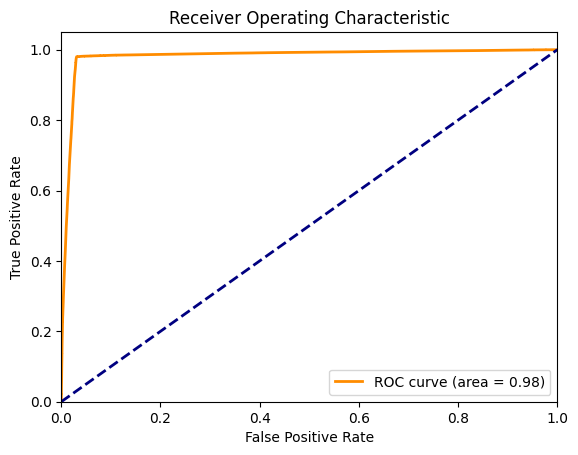

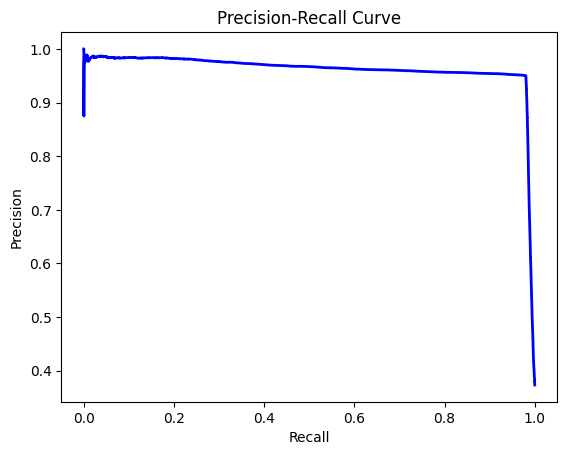


Model evaluation completed.


In [ ]:
# Run the check function
model_path = '/content/drive/My Drive/path_to_save/lgb_tabular_model_v2.txt'
check_model_usability(model_path, train_data, val_data, test_data)

Build Model

In [14]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Define inputs
tabular_input = Input(shape=(16,))
additional_input = Input(shape=(2,))

# Combine tabular data with additional inputs
combined_input = Concatenate()([tabular_input, additional_input])
x = Dense(64, activation='relu')(combined_input)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='softmax')(x)

cnn_tabular_model = Model(inputs=[tabular_input, additional_input], outputs=predictions)
cnn_tabular_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, ReLU, Add
from tensorflow.keras.models import Model

# Define a basic ResNet block for tabular data
def resnet_block(x, units):
    shortcut = x
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


In [11]:

# Define inputs
tabular_input = Input(shape=(16,))
additional_input = Input(shape=(2,))

# Combine tabular data with additional inputs
combined_input = Concatenate()([tabular_input, additional_input])

# Initial dense layer to map input to higher dimensional space
x = Dense(64, activation='relu')(combined_input)

# Add a series of ResNet blocks
for _ in range(3):  # Adjust the number of blocks as needed
    x = resnet_block(x, 64)

# Add final dense layers for classification
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification

# Build the model
tabular_model = Model(inputs=[tabular_input, additional_input], outputs=predictions)


In [12]:
# Compile the model
tabular_model.compile(optimizer='adam',
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])

In [13]:
# Summary of the model
tabular_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 18)                   0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 64)                   1216      ['concatenate[0][0]']     

To make feature computable with Tensor

In [10]:
X_train_balanced = X_train_balanced.astype(float)
X_val =  X_val.astype(float)
X_test =  X_test.astype(float)

additional_train  = additional_train.astype(float)
additional_val = additional_val.astype(float)
additional_test = additional_test.astype(float)

Combine Data

In [11]:
combined_data = np.hstack((X_train_balanced, additional_train))
val_data = np.hstack((X_val, additional_val))


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model_checkpoint = ModelCheckpoint('cnn_best_tabular_model.h5', monitor='val_loss', save_best_only=True)


In [15]:
cnn_tabular_model.fit([combined_data[:, :-2], combined_data[:, -2:]],
                  y_train_balanced,
                  validation_data=([val_data[:, :-2], val_data[:, -2:]], y_val),
                  epochs=50,
                  batch_size=32,
                  callbacks=[early_stopping, cnn_model_checkpoint])


Epoch 1/50
28713/28713 [==============================] - 44s 2ms/step - loss: 0.1165 - accuracy: 0.5000 - val_loss: 0.1235 - val_accuracy: 0.3726
Epoch 2/50
  112/28713 [..............................] - ETA: 39s - loss: 0.1304 - accuracy: 0.5084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28713/28713 [==============================] - 45s 2ms/step - loss: 0.1148 - accuracy: 0.5000 - val_loss: 0.1144 - val_accuracy: 0.3726
Epoch 3/50
28713/28713 [==============================] - 43s 1ms/step - loss: 0.1146 - accuracy: 0.5000 - val_loss: 0.1204 - val_accuracy: 0.3726
Epoch 4/50
28713/28713 [==============================] - 44s 2ms/step - loss: 0.1144 - accuracy: 0.5000 - val_loss: 0.1167 - val_accuracy: 0.3726
Epoch 5/50
28713/28713 [==============================] - 42s 1ms/step - loss: 0.1144 - accuracy: 0.5000 - val_loss: 0.1190 - val_accuracy: 0.3726
Epoch 6/50
28713/28713 [==============================] - 45s 2ms/step - loss: 0.1143 - accuracy: 0.5000 - val_loss: 0.1164 - val_accuracy: 0.3726
Epoch 7/50
28713/28713 [==============================] - 44s 2ms/step - loss: 0.1143 - accuracy: 0.5000 - val_loss: 0.1170 - val_accuracy: 0.3726


Check point for Tabular ResNet50 

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('ResNet50_best_tabular_model.h5', monitor='val_loss', save_best_only=True)


Train Tabular Model

In [18]:
tabular_model.fit([combined_data[:, :-2], combined_data[:, -2:]],
                  y_train_balanced,
                  validation_data=([val_data[:, :-2], val_data[:, -2:]], y_val),
                  epochs=50,
                  batch_size=32,
                  callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
28713/28713 [==============================] - 88s 3ms/step - loss: 0.1166 - accuracy: 0.9745 - val_loss: 0.1144 - val_accuracy: 0.9734
Epoch 2/50
   35/28713 [..............................] - ETA: 1:28 - loss: 0.0990 - accuracy: 0.9795

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28713/28713 [==============================] - 84s 3ms/step - loss: 0.1147 - accuracy: 0.9747 - val_loss: 0.1175 - val_accuracy: 0.9734
Epoch 3/50
28713/28713 [==============================] - 85s 3ms/step - loss: 0.1145 - accuracy: 0.9747 - val_loss: 0.1168 - val_accuracy: 0.9734
Epoch 4/50
28713/28713 [==============================] - 83s 3ms/step - loss: 0.1144 - accuracy: 0.9747 - val_loss: 0.1180 - val_accuracy: 0.9734
Epoch 5/50
28713/28713 [==============================] - 85s 3ms/step - loss: 0.1143 - accuracy: 0.9747 - val_loss: 0.1179 - val_accuracy: 0.9734
Epoch 6/50
28713/28713 [==============================] - 86s 3ms/step - loss: 0.1143 - accuracy: 0.9747 - val_loss: 0.1148 - val_accuracy: 0.9734


Evaluate Model

In [17]:
test_data = np.hstack((X_test, additional_test))

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = tabular_model.evaluate([test_data[:, :-2], test_data[:, -2:]], y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

4916/4916 [==============================] - 7s 1ms/step - loss: 0.1146 - accuracy: 0.9734
Test accuracy: 97.34%


Save Model

In [21]:
tabular_model.save('/content/drive/My Drive/path_to_save/ResNet50_tabular_model_v4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Evaluate the cnn model on the test set
test_loss, test_accuracy = cnn_tabular_model.evaluate([test_data[:, :-2], test_data[:, -2:]], y_test)
print(f'CNN Test accuracy: {test_accuracy * 100:.2f}%')

4916/4916 [==============================] - 5s 1ms/step - loss: 0.1146 - accuracy: 0.3736
CNN Test accuracy: 37.36%


In [20]:
cnn_tabular_model.save('/content/drive/My Drive/path_to_save/CNN_tabular_model_v4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
